In [2]:
import pandas as pd

# Load the dataset
try:
    df = pd.read_csv('Fraud.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: fraud.csv not found. Please make sure the file is uploaded correctly.")
    df = None

# Display the first few rows if the dataset was loaded
if df is not None:
    display(df.head())
    # Display basic information about the dataset
    df.info()

Dataset loaded successfully.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805654 entries, 0 to 1805653
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 151.5+ MB


In [4]:
# Check for missing values
if df is not None:
    print("Missing values before cleaning:")
    print(df.isnull().sum())

Missing values before cleaning:
step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [6]:
# Handle missing values by dropping rows with any missing values
if df is not None:
    df_cleaned = df.dropna()
    print("\nMissing values after dropping rows:")
    print(df_cleaned.isnull().sum())
    print(f"\nOriginal shape: {df.shape}")
    print(f"Shape after dropping missing values: {df_cleaned.shape}")
else:
    df_cleaned = None


Missing values after dropping rows:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Original shape: (1805654, 11)
Shape after dropping missing values: (1805653, 11)


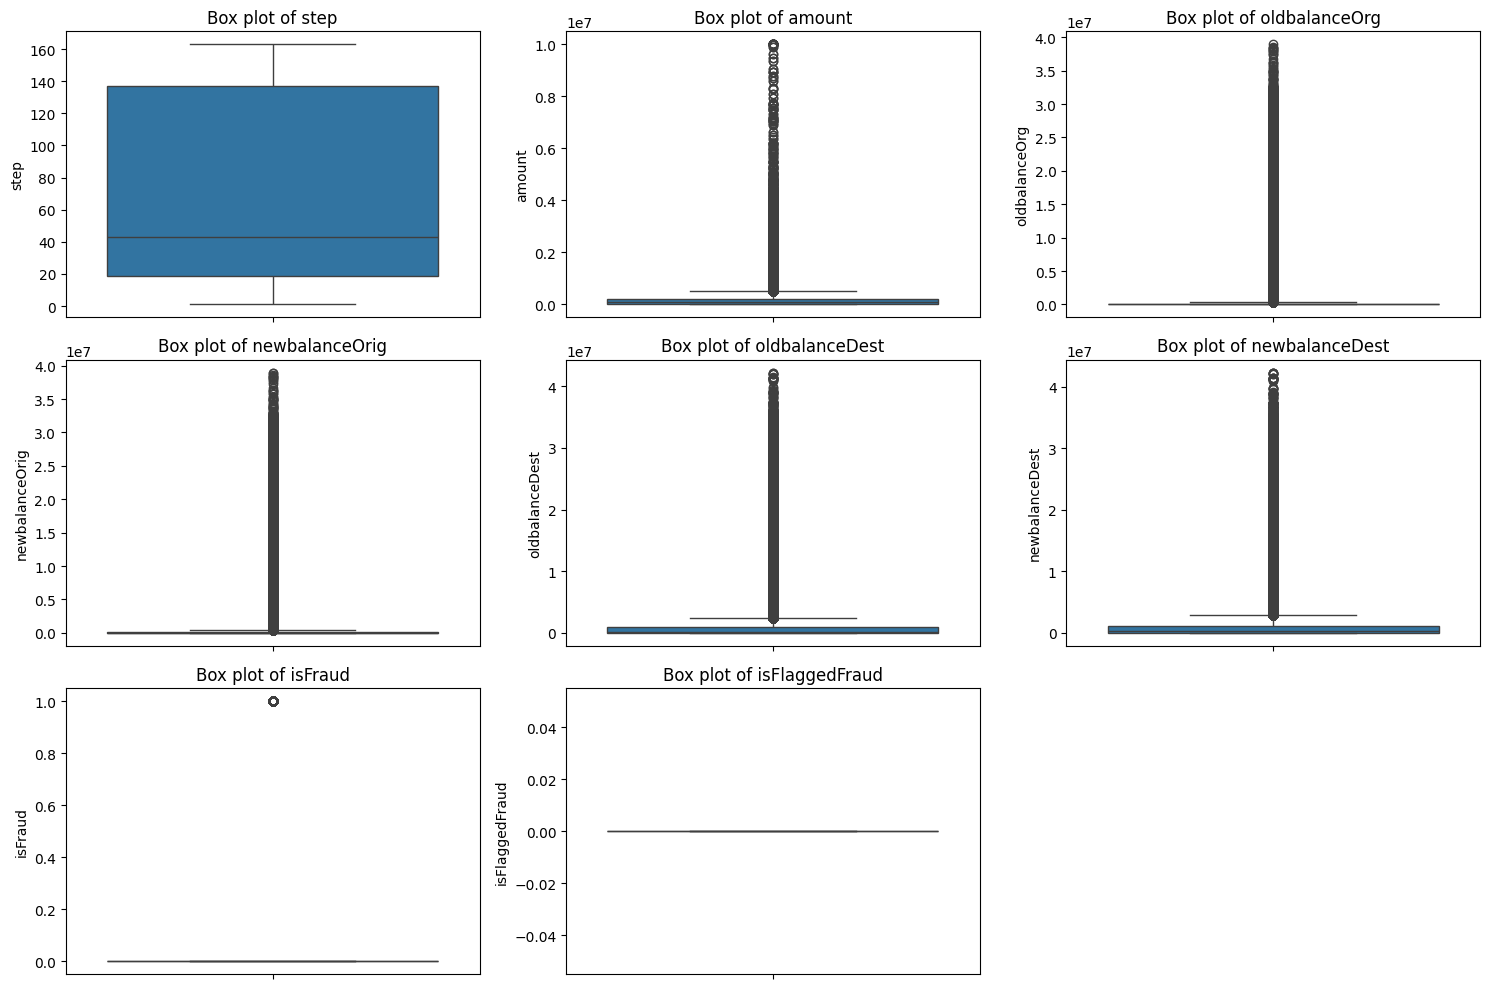

In [7]:
# Check for outliers using box plots
import matplotlib.pyplot as plt
import seaborn as sns

if df_cleaned is not None:
    numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(y=df_cleaned[col])
        plt.title(f'Box plot of {col}')
    plt.tight_layout()
    plt.show()

Outliers have been capped at the 95th percentile.


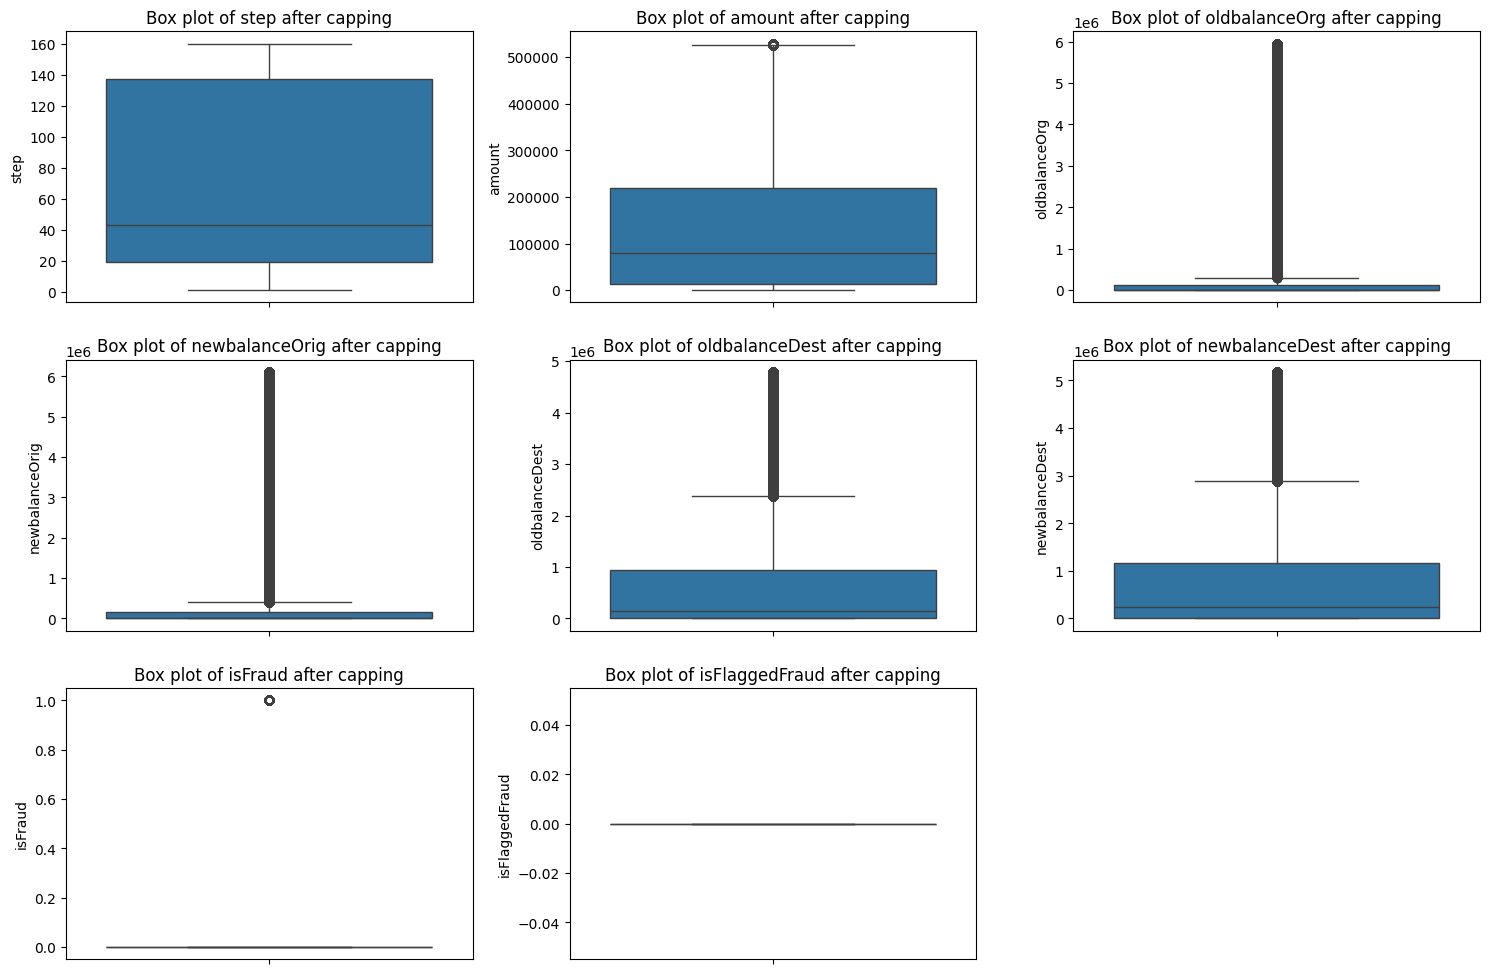

In [9]:
import numpy as np

if df_cleaned is not None:
    # Create a copy to avoid SettingWithCopyWarning
    df_processed = df_cleaned.copy()
    numerical_cols = df_processed.select_dtypes(include=np.number).columns

    # Handle outliers by capping at the 95th percentile
    for col in numerical_cols:
        if col not in ['isFraud', 'isFlaggedFraud']: # Exclude target variables
            upper_limit = df_processed[col].quantile(0.95)
            df_processed[col] = np.where(df_processed[col] > upper_limit, upper_limit, df_processed[col])

    print("Outliers have been capped at the 95th percentile.")

    # Re-display box plots to see the effect of capping
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(y=df_processed[col])
        plt.title(f'Box plot of {col} after capping')
    plt.tight_layout()
    plt.show()
else:
    df_processed = None

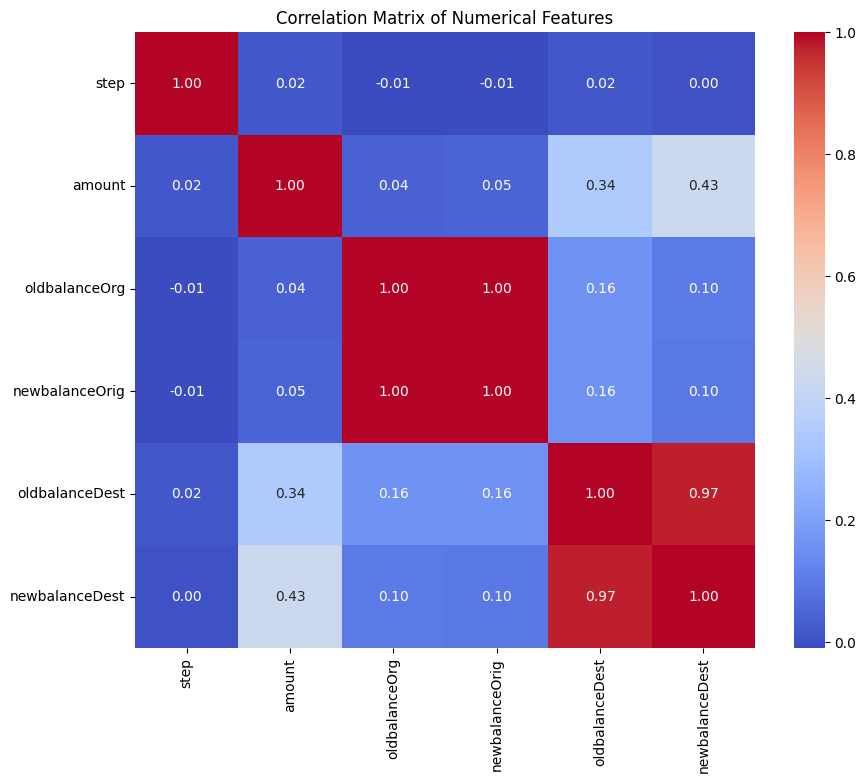


Variance Inflation Factor (VIF):
          feature         VIF
0            step    1.475443
1          amount    2.455540
2   oldbalanceOrg  234.052001
3  newbalanceOrig  238.567941
4  oldbalanceDest   36.729057
5  newbalanceDest   40.562319


In [10]:
# Check for multicollinearity using correlation matrix and VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

if df_processed is not None:
    numerical_cols = df_processed.select_dtypes(include=np.number).columns
    numerical_cols = numerical_cols.drop(['isFraud', 'isFlaggedFraud']) # Exclude target variables

    if len(numerical_cols) > 0:
        # Calculate the correlation matrix
        corr_matrix = df_processed[numerical_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()

        # Calculate VIF for each feature
        X = df_processed[numerical_cols]
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        print("\nVariance Inflation Factor (VIF):")
        print(vif_data)
    else:
        print("No numerical features to check for multicollinearity (excluding target variables).")

In [11]:
if df_processed is not None:
    # Drop columns with high multicollinearity
    df_processed = df_processed.drop(['oldbalanceOrg', 'oldbalanceDest'], axis=1)
    print("Dropped 'oldbalanceOrg' and 'oldbalanceDest' columns.")
    display(df_processed.head())
else:
    print("DataFrame is not available for processing.")

Dropped 'oldbalanceOrg' and 'oldbalanceDest' columns.


,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud
0,1.0,PAYMENT,9839.64,C1231006815,160296.36,M1979787155,0.0,0.0,0.0
1,1.0,PAYMENT,1864.28,C1666544295,19384.72,M2044282225,0.0,0.0,0.0
2,1.0,TRANSFER,181.00,C1305486145,0.00,C553264065,0.0,1.0,0.0
3,1.0,CASH_OUT,181.00,C840083671,0.00,C38997010,0.0,1.0,0.0
4,1.0,PAYMENT,11668.14,C2048537720,29885.86,M1230701703,0.0,0.0,0.0


In [15]:
if df_processed is not None:
    # One-hot encode the 'type' column
    # df_processed = pd.get_dummies(df_processed, columns=['type'], drop_first=True)
    print("One-hot encoded 'type' column.")

    # The following features were removed due to multicollinearity.
    # df_processed['balance_change_orig'] = df_processed['newbalanceOrig'] - df_processed['oldbalanceOrg']
    # df_processed['balance_change_dest'] = df_processed['newbalanceDest'] - df_processed['oldbalanceDest']
    # print("Created balance change features.")

    display(df_processed.head())
else:
    print("DataFrame is not available for processing.")

One-hot encoded 'type' column.


,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1.0,9839.64,C1231006815,160296.36,M1979787155,0.0,0.0,0.0,False,False,True,False
1,1.0,1864.28,C1666544295,19384.72,M2044282225,0.0,0.0,0.0,False,False,True,False
2,1.0,181.00,C1305486145,0.00,C553264065,0.0,1.0,0.0,False,False,False,True
3,1.0,181.00,C840083671,0.00,C38997010,0.0,1.0,0.0,True,False,False,False
4,1.0,11668.14,C2048537720,29885.86,M1230701703,0.0,0.0,0.0,False,False,True,False


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

if df_processed is not None:
    # Define features (X) and target (y)
    # Exclude 'nameOrig' and 'nameDest' as they are identifiers and not useful for training
    # Also exclude 'isFlaggedFraud' as it is highly correlated with isFraud and may not be a good predictive feature
    features = df_processed.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
    target = df_processed['isFraud']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

    print("Data split into training and testing sets.")
    print(f"Training features shape: {X_train.shape}")
    print(f"Testing features shape: {X_test.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Testing target shape: {y_test.shape}")

    # Initialize and train the RandomForestClassifier model
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 to use all available cores
    model.fit(X_train, y_train)

    print("\nRandomForestClassifier model trained successfully.")
else:
    print("DataFrame is not available for model training.")
    X_train, X_test, y_train, y_test, model = None, None, None, None, None

Data split into training and testing sets.
Training features shape: (1444522, 8)
Testing features shape: (361131, 8)
Training target shape: (1444522,)
Testing target shape: (361131,)

RandomForestClassifier model trained successfully.


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

if model is not None and X_test is not None and y_test is not None:
    # Predict on the test set
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)


    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

else:
    print("Model or test data is not available for evaluation.")

Accuracy: 0.9995
Precision: 0.8599
Recall: 0.5925
F1-score: 0.7016
AUC-ROC: 0.8997

Confusion Matrix:
[[360722     36]
 [   152    221]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    360758
         1.0       0.86      0.59      0.70       373

    accuracy                           1.00    361131
   macro avg       0.93      0.80      0.85    361131
weighted avg       1.00      1.00      1.00    361131



Feature Importances:


,feature,importance
3,newbalanceDest,0.370049
0,step,0.368130
1,amount,0.176677
7,type_TRANSFER,0.052492
2,newbalanceOrig,0.021080
4,type_CASH_OUT,0.008705
6,type_PAYMENT,0.002536
5,type_DEBIT,0.000330


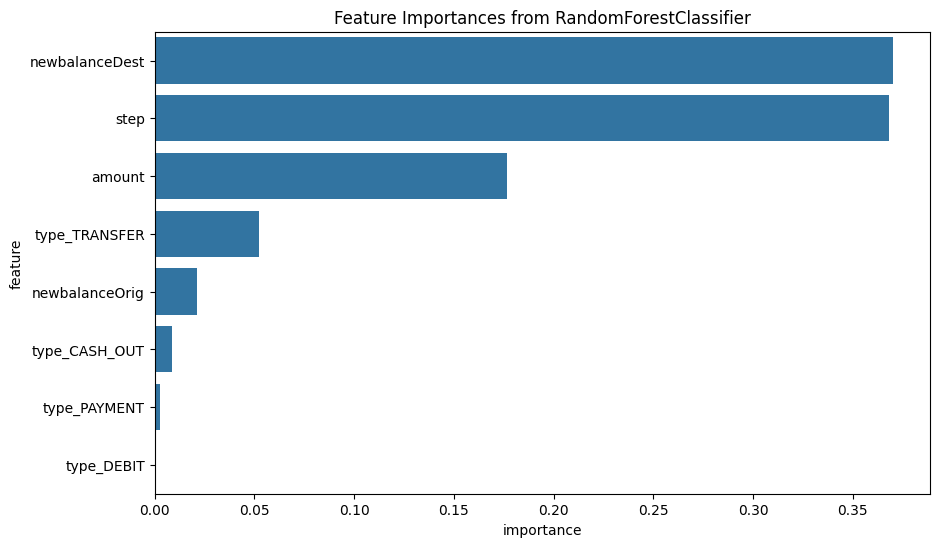

In [19]:
# Get feature importances from the trained model
if model is not None and features is not None:
    importances = model.feature_importances_
    feature_names = features.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print("Feature Importances:")
    display(feature_importance_df)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importances from RandomForestClassifier')
    plt.show()
else:
    print("Model or features not available for feature importance analysis.")